In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10
CLASS_NAMES = [
    'T-shirt/top','Trouser','Pullover','Dress','Coat',
    'Sandal','Shirt','Sneaker','Bag','Ankle boot'
]

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


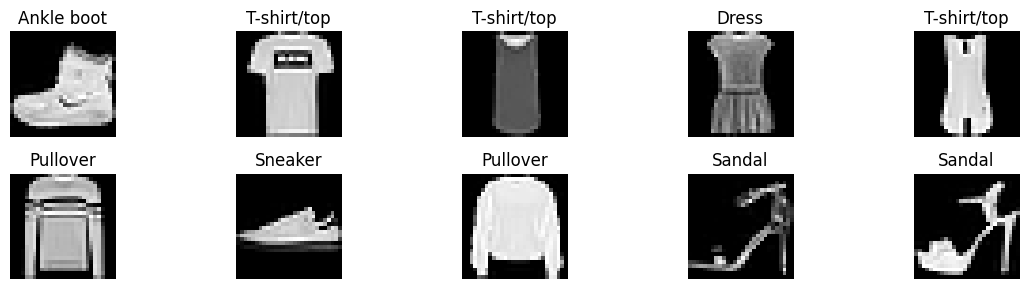

In [4]:
def plot_samples(x, y, class_names):
    plt.figure(figsize=(12, 3))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i], cmap='gray')
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(x_train, y_train, CLASS_NAMES)

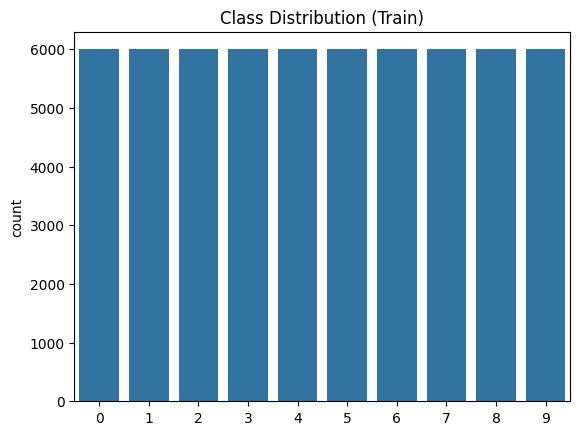

In [5]:
sns.countplot(x=y_train)
plt.title("Class Distribution (Train)")
plt.show();

In [6]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [7]:
x_train_full, x_val, y_train_full, y_val = train_test_split(
    x_train, y_train, test_size=10000, random_state=RANDOM_SEED, stratify=y_train
)

print("Train_full:", x_train_full.shape, y_train_full.shape)
print("Validation:", x_val.shape, y_val.shape)

Train_full: (50000, 28, 28) (50000,)
Validation: (10000, 28, 28) (10000,)


In [8]:
x_train_ch = np.expand_dims(x_train_full, -1)
x_val_ch = np.expand_dims(x_val, -1)
x_test_ch = np.expand_dims(x_test, -1)

In [9]:
y_train_cat = to_categorical(y_train_full, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

In [10]:
aug_gen_small = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

In [11]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title + ' - Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(title + ' - Accuracy')
    plt.legend()
    plt.show();

In [12]:
def build_simple_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def build_lenet(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(6, (5,5), activation='tanh', padding='same', input_shape=input_shape),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.Conv2D(16, (5,5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def build_alexnet_like(input_shape=(28,28,1), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
def train_and_eval(model, train_gen, val_data, epochs=EPOCHS, title="Model"):
    cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
    history = model.fit(train_gen, validation_data=val_data, epochs=epochs, verbose=1)
    plot_history(history, title)
    y_val_pred = np.argmax(model.predict(val_data[0]), axis=1)
    y_val_true = np.argmax(val_data[1], axis=1)
    acc = accuracy_score(y_val_true, y_val_pred)
    prec = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    rec = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    return acc, prec, rec, f1


=== Training SimpleCNN ===
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.5986 - loss: 1.1053 - val_accuracy: 0.7951 - val_loss: 0.5136
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.7548 - loss: 0.6580 - val_accuracy: 0.8390 - val_loss: 0.4267
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.7826 - loss: 0.5741 - val_accuracy: 0.8508 - val_loss: 0.4057
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 88ms/step - accuracy: 0.7977 - loss: 0.5365 - val_accuracy: 0.8672 - val_loss: 0.3599
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.8101 - loss: 0.5037 - val_accuracy: 0.8708 - val_loss: 0.3478
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.8245 - loss: 0.4734 - val_accuracy: 0.8793 - val_loss: 0.3304
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.8259 - loss: 0.4673 - val_accuracy: 0.8795 - val_loss: 0.3199
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accura

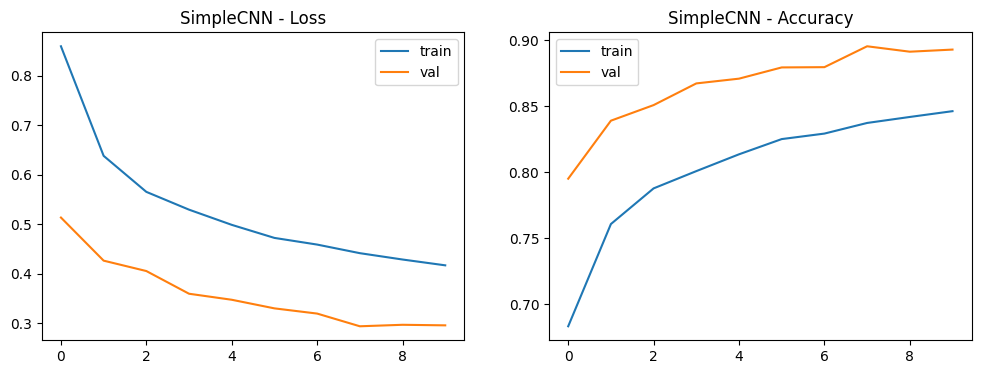

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

=== Training LeNet ===
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step - accuracy: 0.6222 - loss: 1.0237 - val_accuracy: 0.7905 - val_loss: 0.5603
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.7448 - loss: 0.6674 - val_accuracy: 0.7989 - val_loss: 0.5195
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.7688 - loss: 0.6061 - val_accuracy: 0.8176 - val_loss: 0.4771
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - accuracy: 0.7802 - loss: 0.5706 - val_accuracy: 0.8281 - val_loss: 0.4464
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.7947 - loss: 0.5377 - val_accuracy: 0.8282 - val_loss: 0.4430
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.8013 - loss: 0.5164 - val_accuracy: 0.8388 - val_loss: 0.4254
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.8046 - loss: 0.5057 - val_accuracy: 0.8335 - val_loss: 0.4209
Epoch 8/10
782/782 ━━━━━━

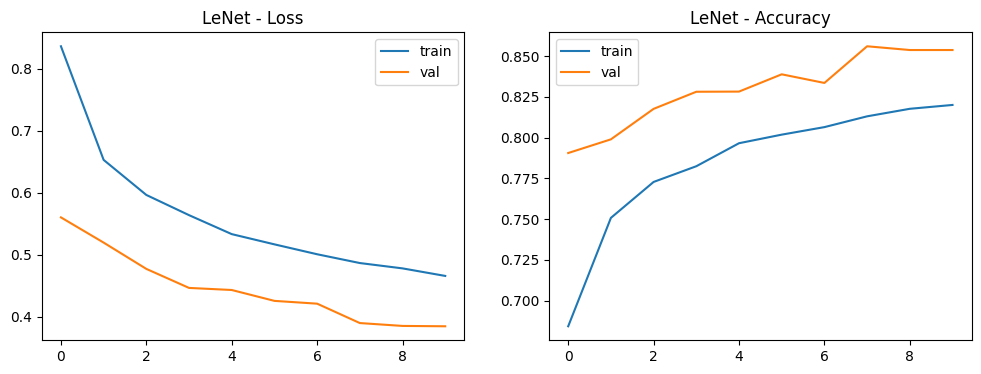

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

=== Training AlexNet-like ===
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 323s 409ms/step - accuracy: 0.6409 - loss: 0.9598 - val_accuracy: 0.8322 - val_loss: 0.4316
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 324s 414ms/step - accuracy: 0.8056 - loss: 0.5118 - val_accuracy: 0.8655 - val_loss: 0.3551
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 345s 441ms/step - accuracy: 0.8409 - loss: 0.4244 - val_accuracy: 0.8732 - val_loss: 0.3350
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 371s 427ms/step - accuracy: 0.8540 - loss: 0.3895 - val_accuracy: 0.8907 - val_loss: 0.2925
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 332s 425ms/step - accuracy: 0.8616 - loss: 0.3630 - val_accuracy: 0.9022 - val_loss: 0.2638
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 376s 417ms/step - accuracy: 0.8713 - loss: 0.3447 - val_accuracy: 0.9005 - val_loss: 0.2653
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 319s 408ms/step - accuracy: 0.8789 - loss: 0.3250 - val_accuracy: 0.9021 - val_loss: 0.2606
Epo

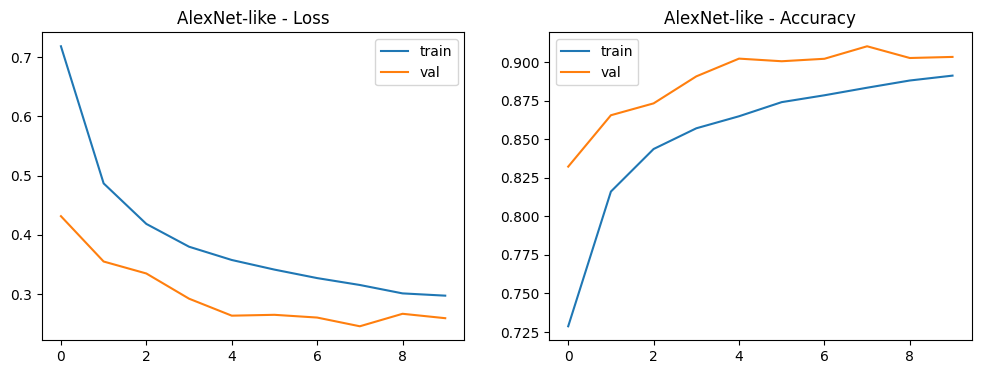

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


In [16]:
results = []

for name, builder in [
    ("SimpleCNN", build_simple_cnn),
    ("LeNet", build_lenet),
    ("AlexNet-like", build_alexnet_like)
]:
    print(f"\n=== Training {name} ===")
    model = builder()
    gen = aug_gen_small.flow(x_train_ch, y_train_cat, batch_size=BATCH_SIZE)
    acc, prec, rec, f1 = train_and_eval(model, gen, (x_val_ch, y_val_cat), title=name)
    results.append((name, acc, prec, rec, f1, model))

In [17]:
df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','Obj'])
df = df.sort_values(by='F1', ascending=False).reset_index(drop=True)
print("\nModel Comparison (Validation):")
print(df[['Model','Accuracy','Precision','Recall','F1']])


Model Comparison (Validation):
          Model  Accuracy  Precision  Recall        F1
0  AlexNet-like    0.9033   0.913728  0.9033  0.905613
1     SimpleCNN    0.8928   0.891831  0.8928  0.891807
2         LeNet    0.8537   0.858306  0.8537  0.853234


In [18]:
best_model_row = df.iloc[0]
best_model = best_model_row['Obj']
best_name = best_model_row['Model']
print(f"\nBest model: {best_name}")


Best model: AlexNet-like


In [19]:
y_pred = np.argmax(best_model.predict(x_test_ch), axis=1)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
correct = (y_test == y_pred).sum()

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step


In [20]:
print(f"\nTest results of best model ({best_name}):")
print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
print(f"Correct predictions: {correct}/{len(y_test)}")


Test results of best model (AlexNet-like):
Accuracy=0.8948, Precision=0.9050, Recall=0.8948, F1=0.8971
Correct predictions: 8948/10000


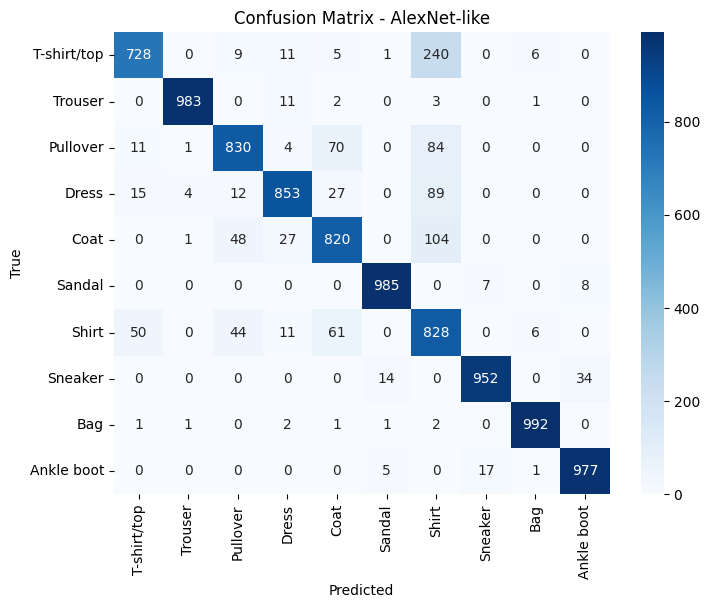

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();